In [5]:
import warnings
from typing import Callable, Dict, List, Optional, Union

from torch import nn, Tensor
from torchvision.ops import misc as misc_nn_ops
from torchvision.ops.feature_pyramid_network import ExtraFPNBlock, FeaturePyramidNetwork, LastLevelMaxPool

from torchvision.models import mobilenet, resnet
from torchvision.models._api import _get_enum_from_fn, WeightsEnum
from torchvision.models._utils import handle_legacy_interface, IntermediateLayerGetter


class BackboneWithFPN(nn.Module):
    """
    Adds a FPN on top of a model.
    Internally, it uses torchvision.models._utils.IntermediateLayerGetter to
    extract a submodel that returns the feature maps specified in return_layers.
    The same limitations of IntermediateLayerGetter apply here.
    Args:
        backbone (nn.Module)
        return_layers (Dict[name, new_name]): a dict containing the names
            of the modules for which the activations will be returned as
            the key of the dict, and the value of the dict is the name
            of the returned activation (which the user can specify).
        in_channels_list (List[int]): number of channels for each feature map
            that is returned, in the order they are present in the OrderedDict
        out_channels (int): number of channels in the FPN.
        norm_layer (callable, optional): Module specifying the normalization layer to use. Default: None
    Attributes:
        out_channels (int): the number of channels in the FPN
    """

    def __init__(
        self,
        backbone: nn.Module,
        return_layers: Dict[str, str],
        in_channels_list: List[int],
        out_channels: int,
        extra_blocks: Optional[ExtraFPNBlock] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()

        if extra_blocks is None:
            extra_blocks = LastLevelMaxPool()

        self.body = IntermediateLayerGetter(backbone, return_layers=return_layers)
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=in_channels_list,
            out_channels=out_channels,
            extra_blocks=extra_blocks,
            norm_layer=norm_layer,
        )
        self.out_channels = out_channels

    def forward(self, x: Tensor) -> Dict[str, Tensor]:
        x = self.body(x)
        x = self.fpn(x)
        return x


@handle_legacy_interface(
    weights=(
        "pretrained",
        lambda kwargs: _get_enum_from_fn(resnet.__dict__[kwargs["backbone_name"]])["IMAGENET1K_V1"],
    ),
)
def resnet_fpn_backbone(
    *,
    backbone_name: str,
    weights: Optional[WeightsEnum],
    norm_layer: Callable[..., nn.Module] = misc_nn_ops.FrozenBatchNorm2d,
    trainable_layers: int = 3,
    returned_layers: Optional[List[int]] = None,
    extra_blocks: Optional[ExtraFPNBlock] = None,
) -> BackboneWithFPN:
    """
    Constructs a specified ResNet backbone with FPN on top. Freezes the specified number of layers in the backbone.

    Examples::

        >>> from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
        >>> backbone = resnet_fpn_backbone('resnet50', weights=ResNet50_Weights.DEFAULT, trainable_layers=3)
        >>> # get some dummy image
        >>> x = torch.rand(1,3,64,64)
        >>> # compute the output
        >>> output = backbone(x)
        >>> print([(k, v.shape) for k, v in output.items()])
        >>> # returns
        >>>   [('0', torch.Size([1, 256, 16, 16])),
        >>>    ('1', torch.Size([1, 256, 8, 8])),
        >>>    ('2', torch.Size([1, 256, 4, 4])),
        >>>    ('3', torch.Size([1, 256, 2, 2])),
        >>>    ('pool', torch.Size([1, 256, 1, 1]))]

    Args:
        backbone_name (string): resnet architecture. Possible values are 'resnet18', 'resnet34', 'resnet50',
             'resnet101', 'resnet152', 'resnext50_32x4d', 'resnext101_32x8d', 'wide_resnet50_2', 'wide_resnet101_2'
        weights (WeightsEnum, optional): The pretrained weights for the model
        norm_layer (callable): it is recommended to use the default value. For details visit:
            (https://github.com/facebookresearch/maskrcnn-benchmark/issues/267)
        trainable_layers (int): number of trainable (not frozen) layers starting from final block.
            Valid values are between 0 and 5, with 5 meaning all backbone layers are trainable.
        returned_layers (list of int): The layers of the network to return. Each entry must be in ``[1, 4]``.
            By default, all layers are returned.
        extra_blocks (ExtraFPNBlock or None): if provided, extra operations will
            be performed. It is expected to take the fpn features, the original
            features and the names of the original features as input, and returns
            a new list of feature maps and their corresponding names. By
            default, a ``LastLevelMaxPool`` is used.
    """
    backbone = resnet.__dict__[backbone_name](weights=weights, norm_layer=norm_layer)
    return _resnet_fpn_extractor(backbone, trainable_layers, returned_layers, extra_blocks)


def _resnet_fpn_extractor(
    backbone: resnet.ResNet,
    trainable_layers: int,
    returned_layers: Optional[List[int]] = None,
    extra_blocks: Optional[ExtraFPNBlock] = None,
    norm_layer: Optional[Callable[..., nn.Module]] = None,
) -> BackboneWithFPN:

    # select layers that won't be frozen
    if trainable_layers < 0 or trainable_layers > 5:
        raise ValueError(f"Trainable layers should be in the range [0,5], got {trainable_layers}")
    layers_to_train = ["layer4", "layer3", "layer2", "layer1", "conv1"][:trainable_layers]
    if trainable_layers == 5:
        layers_to_train.append("bn1")
    for name, parameter in backbone.named_parameters():
        if all([not name.startswith(layer) for layer in layers_to_train]):
            parameter.requires_grad_(False)

    if extra_blocks is None:
        extra_blocks = LastLevelMaxPool()

    if returned_layers is None:
        returned_layers = [1, 2, 3, 4]
    if min(returned_layers) <= 0 or max(returned_layers) >= 5:
        raise ValueError(f"Each returned layer should be in the range [1,4]. Got {returned_layers}")
    return_layers = {f"layer{k}": str(v) for v, k in enumerate(returned_layers)}

    in_channels_stage2 = backbone.inplanes // 8
    in_channels_list = [in_channels_stage2 * 2 ** (i - 1) for i in returned_layers]
    out_channels = 256
    return BackboneWithFPN(
        backbone, return_layers, in_channels_list, out_channels, extra_blocks=extra_blocks, norm_layer=norm_layer
    )


def _validate_trainable_layers(
    is_trained: bool,
    trainable_backbone_layers: Optional[int],
    max_value: int,
    default_value: int,
) -> int:
    # don't freeze any layers if pretrained model or backbone is not used
    if not is_trained:
        if trainable_backbone_layers is not None:
            warnings.warn(
                "Changing trainable_backbone_layers has not effect if "
                "neither pretrained nor pretrained_backbone have been set to True, "
                f"falling back to trainable_backbone_layers={max_value} so that all layers are trainable"
            )
        trainable_backbone_layers = max_value

    # by default freeze first blocks
    if trainable_backbone_layers is None:
        trainable_backbone_layers = default_value
    if trainable_backbone_layers < 0 or trainable_backbone_layers > max_value:
        raise ValueError(
            f"Trainable backbone layers should be in the range [0,{max_value}], got {trainable_backbone_layers} "
        )
    return trainable_backbone_layers


@handle_legacy_interface(
    weights=(
        "pretrained",
        lambda kwargs: _get_enum_from_fn(mobilenet.__dict__[kwargs["backbone_name"]])["IMAGENET1K_V1"],
    ),
)
def mobilenet_backbone(
    *,
    backbone_name: str,
    weights: Optional[WeightsEnum],
    fpn: bool,
    norm_layer: Callable[..., nn.Module] = misc_nn_ops.FrozenBatchNorm2d,
    trainable_layers: int = 2,
    returned_layers: Optional[List[int]] = None,
    extra_blocks: Optional[ExtraFPNBlock] = None,
) -> nn.Module:
    backbone = mobilenet.__dict__[backbone_name](weights=weights, norm_layer=norm_layer)
    return _mobilenet_extractor(backbone, fpn, trainable_layers, returned_layers, extra_blocks)


def _mobilenet_extractor(
    backbone: Union[mobilenet.MobileNetV2, mobilenet.MobileNetV3],
    fpn: bool,
    trainable_layers: int,
    returned_layers: Optional[List[int]] = None,
    extra_blocks: Optional[ExtraFPNBlock] = None,
    norm_layer: Optional[Callable[..., nn.Module]] = None,
) -> nn.Module:
    backbone = backbone.features
    # Gather the indices of blocks which are strided. These are the locations of C1, ..., Cn-1 blocks.
    # The first and last blocks are always included because they are the C0 (conv1) and Cn.
    stage_indices = [0] + [i for i, b in enumerate(backbone) if getattr(b, "_is_cn", False)] + [len(backbone) - 1]
    num_stages = len(stage_indices)

    # find the index of the layer from which we won't freeze
    if trainable_layers < 0 or trainable_layers > num_stages:
        raise ValueError(f"Trainable layers should be in the range [0,{num_stages}], got {trainable_layers} ")
    freeze_before = len(backbone) if trainable_layers == 0 else stage_indices[num_stages - trainable_layers]

    for b in backbone[:freeze_before]:
        for parameter in b.parameters():
            parameter.requires_grad_(False)

    out_channels = 256
    if fpn:
        if extra_blocks is None:
            extra_blocks = LastLevelMaxPool()

        if returned_layers is None:
            returned_layers = [num_stages - 2, num_stages - 1]
        if min(returned_layers) < 0 or max(returned_layers) >= num_stages:
            raise ValueError(f"Each returned layer should be in the range [0,{num_stages - 1}], got {returned_layers} ")
        return_layers = {f"{stage_indices[k]}": str(v) for v, k in enumerate(returned_layers)}

        in_channels_list = [backbone[stage_indices[i]].out_channels for i in returned_layers]
        return BackboneWithFPN(
            backbone, return_layers, in_channels_list, out_channels, extra_blocks=extra_blocks, norm_layer=norm_layer
        )
    else:
        m = nn.Sequential(
            backbone,
            # depthwise linear combination of channels to reduce their size
            nn.Conv2d(backbone[-1].out_channels, out_channels, 1),
        )
        m.out_channels = out_channels  # type: ignore[assignment]
        return m


In [27]:
backbone = mobilenet_v3_large(weights=weights_backbone, progress=progress)

In [11]:
from torchvision.models import mobilenet_v3_large
weights_backbone = None
progress = None
backbone = mobilenet_v3_large(weights=weights_backbone, progress=progress)
backbone = _mobilenet_extractor(backbone, fpn=True, trainable_layers=6, returned_layers=[1, 2, 3, 4])	
mb3_out = backbone(torch.randn(4, 3, 224, 224))

from torchvision.models import resnet50
backbone = resnet50(weights=weights_backbone, progress=progress)
backbone = _resnet_fpn_extractor(backbone, trainable_layers=5, returned_layers=[1, 2, 3, 4])	
r50_out = backbone(torch.randn(4, 3, 224, 224))

from torchvision.models import resnet18
backbone = resnet18(weights=weights_backbone, progress=progress)
backbone = _resnet_fpn_extractor(backbone, trainable_layers=5, returned_layers=[1, 2, 3, 4])	
r18_out = backbone(torch.randn(4, 3, 224, 224))



In [12]:
for k, v in mb3_out.items():
    print(k, v.shape)

for k, v in r50_out.items():
    print(k, v.shape)
    
for k, v in r18_out.items():
    print(k, v.shape)

0 torch.Size([4, 256, 56, 56])
1 torch.Size([4, 256, 28, 28])
2 torch.Size([4, 256, 14, 14])
3 torch.Size([4, 256, 7, 7])
pool torch.Size([4, 256, 4, 4])
0 torch.Size([4, 256, 56, 56])
1 torch.Size([4, 256, 28, 28])
2 torch.Size([4, 256, 14, 14])
3 torch.Size([4, 256, 7, 7])
pool torch.Size([4, 256, 4, 4])
0 torch.Size([4, 256, 56, 56])
1 torch.Size([4, 256, 28, 28])
2 torch.Size([4, 256, 14, 14])
3 torch.Size([4, 256, 7, 7])
pool torch.Size([4, 256, 4, 4])


In [30]:
from torchvision.models import efficientnet_b0, efficientnet_b4, efficientnet_b7 

In [96]:
backbone = efficientnet_b7(weights=None, progress=None)

In [97]:
x = torch.randn(4, 3, 224, 224)
for i, layer in enumerate(backbone.features):
    x = layer(x)
    print(i, x.shape, getattr(layer, "_is_cn", False))

0 torch.Size([4, 64, 112, 112]) False
1 torch.Size([4, 32, 112, 112]) False
2 torch.Size([4, 48, 56, 56]) False
3 torch.Size([4, 80, 28, 28]) False
4 torch.Size([4, 160, 14, 14]) False
5 torch.Size([4, 224, 14, 14]) False
6 torch.Size([4, 384, 7, 7]) False
7 torch.Size([4, 640, 7, 7]) False
8 torch.Size([4, 2560, 7, 7]) False


In [98]:
from torchvision.models import EfficientNet
from torchvision.ops.misc import Conv2dNormActivation

def _efficientnet_extractor(
    backbone: EfficientNet,
    trainable_layers: int,
    returned_layers: Optional[List[int]] = None,
    extra_blocks: Optional[ExtraFPNBlock] = None,
    norm_layer: Optional[Callable[..., nn.Module]] = None,
) -> nn.Module:
    backbone = backbone.features
    # Gather the indices of blocks which are strided. These are the locations of C1, ..., Cn-1 blocks.
    # The first and last blocks are always included because they are the C0 (conv1) and Cn.
    stage_indices = [0, 2, 3, 4, 6]
    num_stages = len(stage_indices)

    # find the index of the layer from which we won't freeze
    if trainable_layers < 0 or trainable_layers > num_stages:
        raise ValueError(f"Trainable layers should be in the range [0,{num_stages}], got {trainable_layers} ")
    freeze_before = len(backbone) if trainable_layers == 0 else stage_indices[num_stages - trainable_layers]

    for b in backbone[:freeze_before]:
        for parameter in b.parameters():
            parameter.requires_grad_(False)

    out_channels = 256
    if extra_blocks is None:
        extra_blocks = LastLevelMaxPool()

    if returned_layers is None:
        returned_layers = [num_stages - 2, num_stages - 1]
    if min(returned_layers) < 0 or max(returned_layers) >= num_stages:
        raise ValueError(f"Each returned layer should be in the range [0,{num_stages - 1}], got {returned_layers} ")
    return_layers = {f"{stage_indices[k]}": str(v) for v, k in enumerate(returned_layers)}
    print(return_layers)
    
    in_channels_list = []
    for i in returned_layers:
        layer = backbone[stage_indices[i]]
        if isinstance(layer, Conv2dNormActivation):
            in_channels_list.append(layer.out_channels)

        else:
            in_channels_list.append(layer[-1].out_channels)
            
    return BackboneWithFPN(
        backbone, return_layers, in_channels_list, out_channels, extra_blocks=extra_blocks, norm_layer=norm_layer
    )



In [99]:
backbone = _efficientnet_extractor(backbone, 5, [1, 2, 3, 4])

{'2': '0', '3': '1', '4': '2', '6': '3'}


In [100]:
eff_out = backbone(torch.randn(4, 3, 224, 224))

In [101]:
for k, v in eff_out.items():
    print(k, v.shape)

0 torch.Size([4, 256, 56, 56])
1 torch.Size([4, 256, 28, 28])
2 torch.Size([4, 256, 14, 14])
3 torch.Size([4, 256, 7, 7])
pool torch.Size([4, 256, 4, 4])


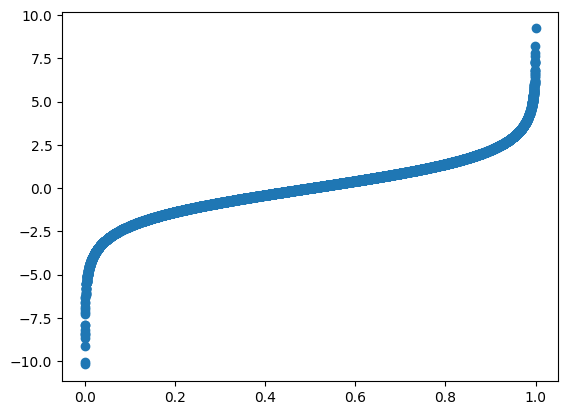

In [1]:
import numpy as np
a = np.random.uniform(0, 1, 10000)
b = np.log(a)-np.log(1-a)
import matplotlib.pyplot as plt
plt.scatter(a, b)